Tổng mẫu sau lọc label: 19569 — SR: 18055 AFIB: 1514
Một record Lead I (ví dụ): (1000,)


100%|██████████| 19569/19569 [01:05<00:00, 296.51it/s]


Beats tổng: (217587, 100)  — SR: 198371  AFIB: 19216 | Bỏ qua: 154
Sau cân bằng: (38432, 100, 1) — mỗi lớp: 19216 19216
Train: (26901, 100, 1) 13450 13451
Val  : (3844, 100, 1) 1922 1922
Test : (7687, 100, 1) 3844 3843
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 16)           96        
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 16)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 25, 

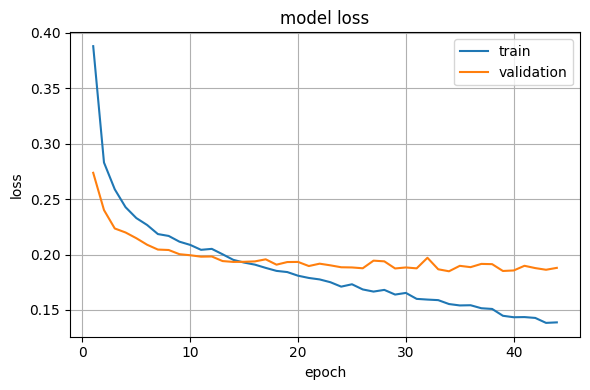

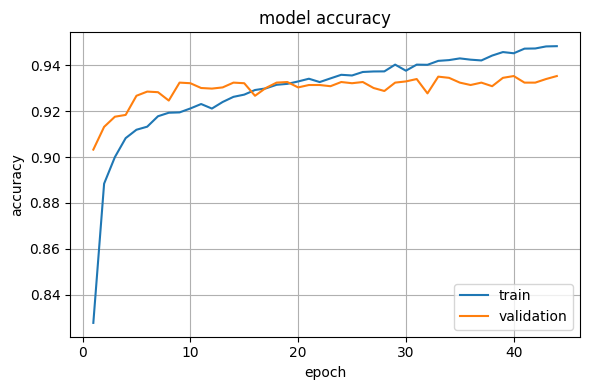

Test accuracy: 0.9337843111747105
Test F1 (macro): 0.9337834326196917
              precision    recall  f1-score   support

          SR       0.94      0.93      0.93      3844
        AFIB       0.93      0.94      0.93      3843

    accuracy                           0.93      7687
   macro avg       0.93      0.93      0.93      7687
weighted avg       0.93      0.93      0.93      7687



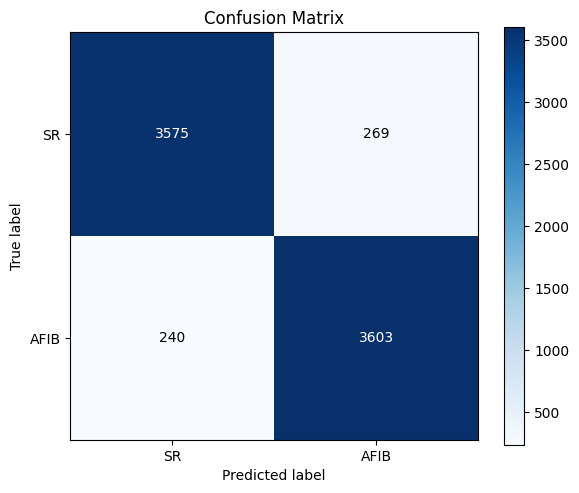

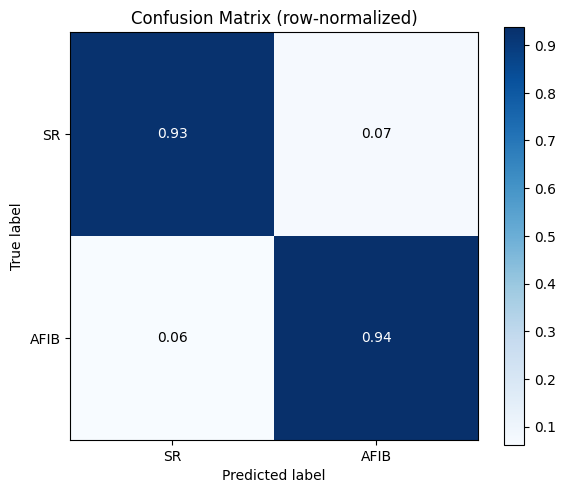

Xong. Ảnh đã lưu: cnn1d_loss.png, cnn1d_acc.png, cnn1d_cm.png, cnn1d_cm_norm.png


In [11]:
# === TinyML AFIB vs SR - Full pipeline 1-cell (improved) ===
import os, ast, random, numpy as np, pandas as pd, wfdb
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             classification_report)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------
# 0) Config & reproducibility
# -----------------------------
SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

PTBXL_ROOT = "/root/AI/Master/project_tinyml/database/physionet.org/files/ptb-xl/1.0.1"
METADATA_CSV = os.path.join(PTBXL_ROOT, "ptbxl_database.csv")
assert os.path.exists(METADATA_CSV), "Sai đường dẫn METADATA_CSV"

FS = 100.0   # 100 Hz
PRE, POST = 40, 60  # 100 mẫu (40 trước, 60 sau)

# -----------------------------
# 1) Đọc metadata & gán nhãn
# -----------------------------
Y = pd.read_csv(METADATA_CSV)

def label_from_scp_codes(scp_str):
    d = ast.literal_eval(scp_str) if isinstance(scp_str, str) else {}
    ks = set(d.keys())
    if "AFIB" in ks:
        return "AFIB"
    for k in ("SR", "NSR", "NORM", "SINUS"):
        if k in ks:
            return "SR"
    return None

Y["target"] = Y["scp_codes"].apply(label_from_scp_codes)
df = Y[Y["target"].isin(["SR","AFIB"])].copy()
print("Tổng mẫu sau lọc label:", len(df), "— SR:", (df.target=="SR").sum(), "AFIB:", (df.target=="AFIB").sum())

# -----------------------------
# 2) Đọc sóng 100 Hz & chỉ Lead I
# -----------------------------
def read_lead_I_row(row):
    rec_rel  = row["filename_lr"]                 # ví dụ "records100/00000/00001_lr"
    rec_path = os.path.join(PTBXL_ROOT, rec_rel)
    try:
        rec = wfdb.rdrecord(rec_path, physical=True)
        sig = rec.p_signal.astype(np.float32)
        lead_names = [s.upper() for s in rec.sig_name]
    except Exception:
        sig, fields = wfdb.rdsamp(rec_path)
        sig = sig.astype(np.float32)
        lead_names = [s.upper() for s in fields.get("sig_name", [])]

    # CHỈ nhận Lead I
    if "I" in lead_names:
        idx = lead_names.index("I")
        return sig[:, idx]
    if "LEAD I" in lead_names:
        idx = lead_names.index("LEAD I")
        return sig[:, idx]
    return None  # không có Lead I → bỏ record

x_demo = read_lead_I_row(df.iloc[0])
print("Một record Lead I (ví dụ):", None if x_demo is None else x_demo.shape)

# -----------------------------
# 3) Lọc tín hiệu, R-peak, cắt nhịp, chuẩn hoá
# -----------------------------
def butter_highpass(data, fc=0.5, order=4, fs=FS):
    b, a = butter(order, fc/(0.5*fs), btype='high')
    return filtfilt(b, a, data)

def butter_lowpass(data, fc=41.0, order=3, fs=FS):
    b, a = butter(order, fc/(0.5*fs), btype='low')
    return filtfilt(b, a, data)

def preprocess_record(x):
    x = butter_highpass(x, 0.5, 4, FS)
    x = butter_lowpass(x, 41.0, 3, FS)
    return x

def detect_r_peaks(x, fs=FS, thresh_frac=0.5, refractory_ms=200):
    x = np.asarray(x)
    thr = thresh_frac * np.max(np.abs(x))
    refr = int(round(refractory_ms * fs / 1000.0))
    peaks, last = [], -refr
    for i in range(1, len(x)-1):
        if x[i] > thr and x[i] >= x[i-1] and x[i] >= x[i+1]:
            if i - last >= refr:
                peaks.append(i); last = i
    return np.array(peaks, dtype=int)

def extract_beats(x, rpos, pre=PRE, post=POST):
    beats = []
    for r in rpos:
        a, b = r-pre, r+post
        if a >= 0 and b <= len(x):
            beats.append(x[a:b])
    return np.asarray(beats, dtype=np.float32)

def normalize_beats(X):
    Xn = np.empty_like(X)
    for i, b in enumerate(X):
        m, s = b.mean(), b.std() + 1e-8
        Xn[i] = (b - m) / s
    return Xn

# -----------------------------
# 4) Tạo tập nhịp từ toàn bộ record
# -----------------------------
all_beats, all_labels, all_patients = [], [], []
skipped = 0

for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        x_raw = read_lead_I_row(row)
        if x_raw is None:
            skipped += 1; continue
        x = preprocess_record(x_raw)
        rpos = detect_r_peaks(x)
        beats = extract_beats(x, rpos)
        if len(beats) == 0:
            skipped += 1; continue
        beats = normalize_beats(beats)

        all_beats.append(beats)
        y_val = 1 if row["target"] == "AFIB" else 0
        all_labels.append(np.full(len(beats), y_val, dtype=np.int64))
        pid = int(row.get("patient_id", row.get("ecg_id", -1)))
        all_patients.append(np.full(len(beats), pid, dtype=np.int64))
    except Exception:
        skipped += 1
        continue

X = np.vstack(all_beats)               # (N_beats, 100)
y = np.concatenate(all_labels)         # (N_beats,)
patients = np.concatenate(all_patients)# (N_beats,)
print("Beats tổng:", X.shape, " — SR:", (y==0).sum(), " AFIB:", (y==1).sum(), "| Bỏ qua:", skipped)

# cho Conv1D: thêm trục kênh
X = X[..., None]  # (N, 100, 1)

# -----------------------------
# 5) Cân bằng lớp (downsample không thay thế)
# -----------------------------
rng = np.random.default_rng(SEED)
idx0 = np.where(y==0)[0]
idx1 = np.where(y==1)[0]
m = min(len(idx0), len(idx1))
idx0 = rng.choice(idx0, size=m, replace=False)
idx1 = rng.choice(idx1, size=m, replace=False)
sel = np.sort(np.concatenate([idx0, idx1]))

Xb, yb, patients_b = X[sel], y[sel], patients[sel]
print("Sau cân bằng:", Xb.shape, "— mỗi lớp:", (yb==0).sum(), (yb==1).sum())

# -----------------------------
# 6) Chia Train/Val/Test = 70/10/20 (stratified, theo beat)
# -----------------------------
X_tmp, Xte, y_tmp, yte = train_test_split(
    Xb, yb, test_size=0.20, random_state=SEED, stratify=yb
)
Xtr, Xva, ytr, yva = train_test_split(
    X_tmp, y_tmp, test_size=0.125, random_state=SEED, stratify=y_tmp
)
print("Train:", Xtr.shape, (ytr==0).sum(), (ytr==1).sum())
print("Val  :", Xva.shape, (yva==0).sum(), (yva==1).sum())
print("Test :", Xte.shape, (yte==0).sum(), (yte==1).sum())

# -----------------------------
# 7) Model 1D-CNN (gọn, đúng tinh thần bài)
# -----------------------------
def build_cnn1d_model(input_len=100, n_classes=2, learning_rate=5e-4, dropout=0.2):
    inp = layers.Input(shape=(input_len, 1))
    x = layers.Conv1D(16, 5, padding='same', activation='relu')(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(32, 5, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tf.keras.backend.clear_session()
model = build_cnn1d_model()
model.summary()

# -----------------------------
# 8) Train + callbacks
# -----------------------------
es  = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=1)  # tùy chọn
hist = model.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=100,
    batch_size=128,
    callbacks=[es, rlr],
    verbose=2
)

# Best epoch info
best_ep = int(np.argmin(hist.history['val_loss'])) + 1
best_vl = float(np.min(hist.history['val_loss']))
best_va = float(hist.history.get('val_accuracy',[np.nan])[best_ep-1])
print(f"[Best] epoch={best_ep} | val_loss={best_vl:.4f} | val_acc={best_va:.4f}")

# -----------------------------
# 9) Plot learning curves
# -----------------------------
def save_history_plots(hist, prefix="cnn1d"):
    h = hist.history
    epochs = range(1, len(h['loss'])+1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, h['loss'], label='train')
    if 'val_loss' in h: plt.plot(epochs, h['val_loss'], label='validation')
    plt.title('model loss'); plt.xlabel('epoch'); plt.ylabel('loss')
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.savefig(f'{prefix}_loss.png', dpi=200); plt.show()

    if 'accuracy' in h:
        plt.figure(figsize=(6,4))
        plt.plot(epochs, h['accuracy'], label='train')
        if 'val_accuracy' in h: plt.plot(epochs, h['val_accuracy'], label='validation')
        plt.title('model accuracy'); plt.xlabel('epoch'); plt.ylabel('accuracy')
        plt.legend(); plt.grid(True); plt.tight_layout()
        plt.savefig(f'{prefix}_acc.png', dpi=200); plt.show()

save_history_plots(hist, prefix="cnn1d")

# -----------------------------
# 10) Đánh giá cuối cùng trên Test + plot CM
# -----------------------------
def plot_cm(cm, classes=('SR','AFIB'), normalize=False, fname=None, title='Confusion Matrix'):
    import itertools
    cm_plot = cm.astype(float)
    if normalize:
        cm_sum = cm_plot.sum(axis=1, keepdims=True)
        cm_plot = np.divide(cm_plot, cm_sum, out=np.zeros_like(cm_plot), where=cm_sum!=0)
    plt.figure(figsize=(6,5))
    plt.imshow(cm_plot, cmap='Blues', interpolation='nearest')
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes); plt.yticks(ticks, classes)
    thresh = cm_plot.max()/2. if cm_plot.size else 0.5
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            txt = f"{cm_plot[i,j]:.2f}" if normalize else f"{int(cm_plot[i,j])}"
            plt.text(j, i, txt, ha='center', va='center',
                     color='white' if cm_plot[i,j] > thresh else 'black')
    plt.ylabel('True label'); plt.xlabel('Predicted label')
    plt.tight_layout()
    if fname: plt.savefig(fname, dpi=200)
    plt.show()

def evaluate_on_test(model, X, y, names=('SR','AFIB'), prefix='cnn1d'):
    y_prob = model.predict(X, verbose=0)   # (N,2)
    y_pred = np.argmax(y_prob, axis=1)
    print("Test accuracy:", accuracy_score(y, y_pred))
    print("Test F1 (macro):", f1_score(y, y_pred, average='macro'))
    print(classification_report(y, y_pred, digits=2, target_names=list(names)))
    cm = confusion_matrix(y, y_pred)
    plot_cm(cm, classes=names, fname=f'{prefix}_cm.png')
    plot_cm(cm, classes=names, normalize=True, fname=f'{prefix}_cm_norm.png',
            title='Confusion Matrix (row-normalized)')
    return cm

cm = evaluate_on_test(model, Xte, yte, names=('SR','AFIB'), prefix='cnn1d')

print("Xong. Ảnh đã lưu: cnn1d_loss.png, cnn1d_acc.png, cnn1d_cm.png, cnn1d_cm_norm.png")
